## Neural Nets
You  must also try to do digit recognition using neural nets, in particular in Googles Open Source Framework, Tensorflow. Read the guide the TA gratiously has provided for you. 

### Deliverables
You must try using a classific neural net with one input layer, one hidden layer, and one output layer.
You can chosse whichever non-linear activation function you want but we suggest using logistic or rectified linear unit (relu).  You must again experiment with the hyperparameters, in particular
network size (hidden layer) and regularization (weight decay, droupout), and use
validation to find the best combination for the digits data. The validation data should come from the training data not the test data.

## Report
In the report, explain what you have done and and provide
tables that show your results. Include tables of your validation
results for all the SVMs and Neural Nets you have tested as well as the out 
of sample error/accuracy computed using the test set for the best SVM and the neural net you have found so far.


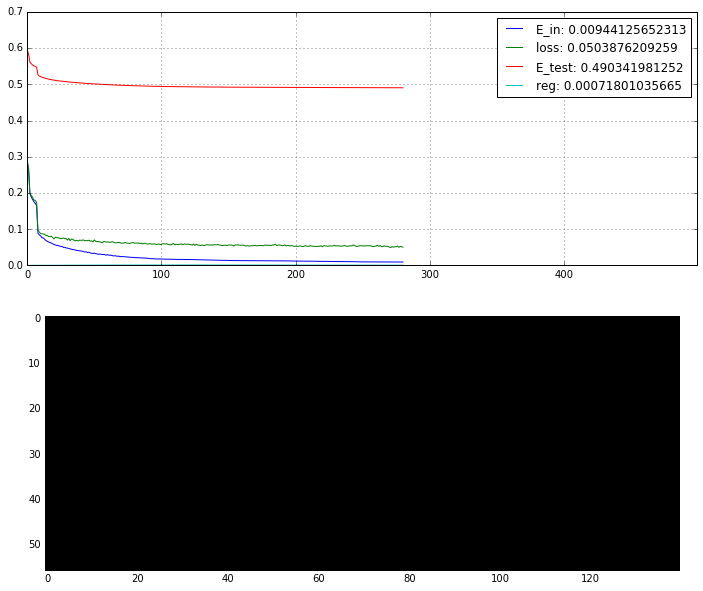

In [ ]:

%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

auTrain = np.load('auTrain.npz')
auTrain_images = auTrain['digits']
auTrain_labels = auTrain['labels']
auTest = np.load('auTest.npz')
auTest_images = auTest['digits']
auTest_labels = auTest['labels']
batch_size = 16
epochs = 500
d = auTrain_images.shape[1]

def plot_perf(names, fig=None, ax=None, xlim=None, ylim=None, figsize=(15, 10)):
    import matplotlib
    from IPython.display import display, clear_output

    formats = ['%s: %%s' % n for n in names]
    n = len(formats)

    if ax is None or isinstance(ax, int):
        if fig is None:
            fig = matplotlib.figure.Figure(figsize=figsize)
            fig.canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)

        if isinstance(ax, int):
            ax = fig.add_subplot(ax)
        else:
            ax = fig.gca()
        if xlim is None:
            ax.set_autoscalex_on(True)
        else:
            ax.set_autoscalex_on(False)
            ax.set_xlim(*xlim)
        if ylim is None:
            ax.set_autoscaley_on(True)
        else:
            ax.set_autoscaley_on(False)
            ax.set_ylim(*ylim)
        ax.grid()
    lines = [([], [], ax.plot([], [])[0]) for _ in range(n)]

    def add(*points):
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        for y, (xs, ys, line) in zip(points, lines):
            xs.append(len(xs))
            ys.append(y)
            line.set_data(xs, ys)
        ax.legend([f % p for f, p in zip(formats, points)])
        ax.relim()
        ax.autoscale(enable=None)
        clear_output(wait=True)
        display(fig)

    return fig, add

def permute_data_all():
    assert auTrain_images.flags.c_contiguous
    # Return a random permutation of the data
    perm = np.random.permutation(len(auTrain_labels))
    return auTrain_images[perm], auTrain_labels[perm]

def main():

    with tf.Graph().as_default():
        
        data = tf.placeholder(tf.float32, shape = [None, 784])
        labels = tf.placeholder(tf.int32, shape = [None])
        learning_rate = tf.placeholder(tf.float32)
        #layer 1
        W1 = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1))
        b1 = tf.Variable(tf.truncated_normal([100], stddev=0.1))
        y1 = tf.nn.relu(tf.matmul(data, W1) + b1)

        #Output
        W2 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
        b2 = tf.Variable(tf.truncated_normal([10], stddev=0.1))
        y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)

        correct_prediction = tf.equal(labels, tf.cast(tf.argmax(y2, 1), labels.dtype))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        y2, labels)
        reg_rate = 1e-4
        loss = tf.reduce_mean(cross_entropy)
        reg = reg_rate * tf.reduce_sum(W2 ** 2)
        # Minimization target is the sum of cross-entropy loss and regularization
        target = loss + reg

        opt = tf.train.AdamOptimizer(learning_rate)
        train_step = opt.minimize(target)
        fig, perf = plot_perf(names=['E_in', 'loss', 'E_test', 'reg'],
                          ax=211, xlim=(0, epochs-1), ylim=(0, 0.7), figsize=(12, 10))
        weight_ax = fig.add_subplot(212)
        weight_image = weight_ax.imshow(np.zeros((2*28, 5*28)), cmap='bone')

        
        
        
        with tf.Session() as session:
            session.run(tf.initialize_all_variables())

            for epoch in range(epochs):
                input_value, labels_value = permute_data_all()
    
                # Run train_step in mini-batches
                for i in range(0, len(auTrain_labels), batch_size):
                    j = min(len(auTrain_labels), i+batch_size)
                    results = session.run(
                        train_step,
                        feed_dict={data: input_value[i:j],
                                   labels: labels_value[i:j],
                                   learning_rate: 1e-4})

                train_accuracy = session.run(accuracy,feed_dict={data: auTrain_images, labels: auTrain_labels})
                correctly_labeled = session.run(correct_prediction, feed_dict={data: auTest_images, labels: auTest_labels})
                print(correctly_labeled)
                test_accuracy = session.run(accuracy, feed_dict={data: auTest_images, labels: auTest_labels})
                test_error = 1 - test_accuracy
                current_loss = session.run(loss, feed_dict={data: auTrain_images, labels: auTrain_labels})
                in_sample_error = 1 - train_accuracy
                perf(in_sample_error, test_error, current_loss/3, session.run(reg)/3)

            test_accuracy = session.run( accuracy,
            feed_dict={data: auTest_images,
                       labels: auTest_labels})
            test_error = 1 - test_accuracy
            print(test_error)
            
            
if __name__ == '__main__':
    print(main())